In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

In [2]:
## Check CASES folder exists
cases_folder = Path("CASES_5mgDOC")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [3]:
rho_x_list = [1, 3, 10, 31, 100, 316, 1000]  ## Values chosen so they are nice powers of 10
d_growth_list = [0, 1e-11, 1e-10, 1e-9, 1e-8]
cases_objs = dict()

## Assemble cases
for rho_x, d_growth in itertools.product(
    rho_x_list, d_growth_list
):

    identifier = cases_folder / f"rhox_{rho_x}__dgrowth_{d_growth}"
    of = OpenFOAM(
        path_case=identifier, write_to_log = True, path_template=template_folder
    )

    of.set_value_in_foamDictionary(
        location="constant/transportProperties", 
        entry="rho_X",
        value=f"rho_X   [1 -3 0 0 0 0 0] {rho_x:.1f}")
    
    of.set_value_in_foamDictionary( 
        location="constant/transportProperties", 
        entry="diffusiveGrowth",
        value=f"diffusiveGrowth [0 2 -1 0 0 0 0] {d_growth:.2e}")

    ## To change the DOC concentration
    of.set_value_in_foamDictionary( 
        location="0.000/DOC", 
        entry="internalField",
        value=f"uniform 5.0E-3")

    of.set_value_in_foamDictionary( 
        location="0.000/DOC", 
        entry="boundaryField.top.uniformInletValue",
        value=f"constant 5.0E-3")

    cases_objs[str(identifier)] = of

In [4]:
cases_objs[str(cases_folder / "rhox_10__dgrowth_1e-09")]

OpenFOAM(path_case=PosixPath('CASES_5mgDOC/rhox_10__dgrowth_1e-09'), path_template=PosixPath('template'), write_to_log=True)

In [5]:
with mp.Pool(processes=24) as pool:
    pool.map(OpenFOAM.run_solver, cases_objs.values())

In [6]:
## Disable if got rid of the cases and need to rerun/convert to vtk

# with mp.Pool() as pool:
#     pool.map(OpenFOAM.foam_to_vtk, cases_objs.values())

# with mp.Pool() as pool:
#     pool.map(OpenFOAM.boundaryProbes_to_txt, cases_objs.values())

In [7]:
import json

field = "XAR"

with open("heatmaps_config.json") as f:
    heatmaps_config = json.load(f)

default_pcolormesh_kwargs = dict(vmin=0, cmap="winter")
pcolormesh_kwargs = heatmaps_config.get(field) or default_pcolormesh_kwargs

# with mp.Pool() as pool:
#     figs = pool.starmap(
#         OpenFOAM.plot_field_over_time,
#         [(of, field, pcolormesh_kwargs) for of in cases_objs.values()],
#     )

In [8]:
field = "XAR"

with mp.Pool() as pool:
    data = pool.starmap(
        OpenFOAM.read_field_all_times,
        [(of, field) for of in cases_objs.values()],
    )

In [9]:
data[0].t

<xarray.DataArray 't' (t: 116)>
array([  17272.485,   34552.485,   51832.485,   69112.485,   86392.485,
        103672.485,  120952.485,  138232.485,  155512.485,  172792.485,
        190072.485,  207352.485,  224632.485,  241912.485,  259192.485,
        276472.485,  293752.485,  311032.485,  328312.485,  345592.485,
        362872.485,  380152.485,  397432.485,  414712.485,  431992.485,
        449272.485,  466552.485,  483832.485,  501112.485,  518392.485,
        535672.485,  552952.485,  570232.485,  587512.485,  604792.485,
        622072.485,  639352.485,  656632.485,  673912.485,  691192.485,
        708472.485,  725752.485,  743032.485,  760312.485,  777592.485,
        794872.485,  812152.485,  829432.485,  846712.485,  863992.485,
        881272.485,  898552.485,  915832.485,  933112.485,  950392.485,
        967672.485,  984952.485, 1002232.485, 1019512.485, 1036792.485,
       1054072.485, 1071352.485, 1088632.485, 1105912.485, 1123192.485,
       1140472.485, 1157752.485, 1175032.485, 1192312.485, 1209592.485,
       1226872.485, 1244152.485, 1261432.485, 1278712.485, 1295992.485,
       1313272.485, 1330552.485, 1347832.485, 1365112.485, 1382392.485,
       1399672.485, 1416952.485, 1434232.485, 1451512.485, 1468792.485,
       1486072.485, 1503352.485, 1520632.485, 1537912.485, 1555192.485,
       1572472.485, 1589752.485, 1607032.485, 1624312.485, 1641592.485,
       1658872.485, 1676152.485, 1693432.485, 1710712.485, 1727992.485,
       1745272.485, 1762552.485, 1779832.485, 1797112.485, 1814392.485,
       1831672.485, 1848952.485, 1866232.485, 1883512.485, 1900792.485,
       1918072.485, 1935352.485, 1952632.485, 1969912.485, 1987192.485,
       1987200.   ])
Coordinates:
  * t        (t) float64 1.727e+04 3.455e+04 5.183e+04 ... 1.987e+06 1.987e+06

In [10]:
labels = cases_objs.keys()
for label in labels:
    print(label)

CASES_5mgDOC/rhox_1__dgrowth_0
CASES_5mgDOC/rhox_1__dgrowth_1e-11
CASES_5mgDOC/rhox_1__dgrowth_1e-10
CASES_5mgDOC/rhox_1__dgrowth_1e-09
CASES_5mgDOC/rhox_1__dgrowth_1e-08
CASES_5mgDOC/rhox_3__dgrowth_0
CASES_5mgDOC/rhox_3__dgrowth_1e-11
CASES_5mgDOC/rhox_3__dgrowth_1e-10
CASES_5mgDOC/rhox_3__dgrowth_1e-09
CASES_5mgDOC/rhox_3__dgrowth_1e-08
CASES_5mgDOC/rhox_10__dgrowth_0
CASES_5mgDOC/rhox_10__dgrowth_1e-11
CASES_5mgDOC/rhox_10__dgrowth_1e-10
CASES_5mgDOC/rhox_10__dgrowth_1e-09
CASES_5mgDOC/rhox_10__dgrowth_1e-08
CASES_5mgDOC/rhox_31__dgrowth_0
CASES_5mgDOC/rhox_31__dgrowth_1e-11
CASES_5mgDOC/rhox_31__dgrowth_1e-10
CASES_5mgDOC/rhox_31__dgrowth_1e-09
CASES_5mgDOC/rhox_31__dgrowth_1e-08
CASES_5mgDOC/rhox_100__dgrowth_0
CASES_5mgDOC/rhox_100__dgrowth_1e-11
CASES_5mgDOC/rhox_100__dgrowth_1e-10
CASES_5mgDOC/rhox_100__dgrowth_1e-09
CASES_5mgDOC/rhox_100__dgrowth_1e-08
CASES_5mgDOC/rhox_316__dgrowth_0
CASES_5mgDOC/rhox_316__dgrowth_1e-11
CASES_5mgDOC/rhox_316__dgrowth_1e-10
CASES_5mgDOC/rhox_

In [11]:
import matplotlib as mpl
from itertools import cycle

cmap = mpl.cm.Dark2
# colors = cmap(range(len(d_growth_list)))  # Colors to differentiate d_growth
colors = ['#fbb4b9','#f768a1','#c51b8a','#7a0177','black']

In [12]:
for of in cases_objs.values():
    of.process_boundaryProbes()

In [13]:
flow_end = list()

for label, of in cases_objs.items():
    for bp in of.boundaryProbes:  ## Probe for vector data, another for scalar data
        for k, v in bp.array_data.items():
            if k == "Uz":
                print(label[6:], f"{v.values[0][-1]/v.values[0][0]=:.5f}", sep="\t")
                flow_end.append(v.values[0][-1]/v.values[0][0])

5mgDOC/rhox_1__dgrowth_0	v.values[0][-1]/v.values[0][0]=0.29649
5mgDOC/rhox_1__dgrowth_1e-11	v.values[0][-1]/v.values[0][0]=0.29586
5mgDOC/rhox_1__dgrowth_1e-10	v.values[0][-1]/v.values[0][0]=0.30039
5mgDOC/rhox_1__dgrowth_1e-09	v.values[0][-1]/v.values[0][0]=0.36183
5mgDOC/rhox_1__dgrowth_1e-08	v.values[0][-1]/v.values[0][0]=0.50022
5mgDOC/rhox_3__dgrowth_0	v.values[0][-1]/v.values[0][0]=0.55859
5mgDOC/rhox_3__dgrowth_1e-11	v.values[0][-1]/v.values[0][0]=0.55701
5mgDOC/rhox_3__dgrowth_1e-10	v.values[0][-1]/v.values[0][0]=0.55859
5mgDOC/rhox_3__dgrowth_1e-09	v.values[0][-1]/v.values[0][0]=0.61448
5mgDOC/rhox_3__dgrowth_1e-08	v.values[0][-1]/v.values[0][0]=0.73283
5mgDOC/rhox_10__dgrowth_0	v.values[0][-1]/v.values[0][0]=0.82117
5mgDOC/rhox_10__dgrowth_1e-11	v.values[0][-1]/v.values[0][0]=0.82006
5mgDOC/rhox_10__dgrowth_1e-10	v.values[0][-1]/v.values[0][0]=0.81898
5mgDOC/rhox_10__dgrowth_1e-09	v.values[0][-1]/v.values[0][0]=0.84233
5mgDOC/rhox_10__dgrowth_1e-08	v.values[0][-1]/v.values[0

In [14]:
flow_end = np.array(flow_end)
flow_end = np.reshape(flow_end, (len(rho_x_list), len(d_growth_list)))


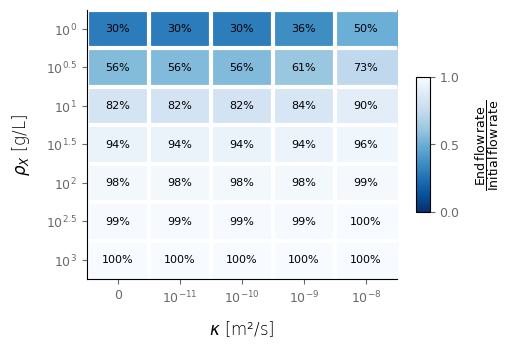

In [15]:
fig, ax = plt.subplots(figsize=(5,3.5))
im = ax.imshow(flow_end, cmap="Blues_r", vmin=0, vmax=1, aspect="auto")
cb = fig.colorbar(im, shrink=0.5, aspect=10, pad=0.05)

cb.ax.set_ylabel(r"$\dfrac{\mathsf{End\,flow\,rate}}{\mathsf{Initial\,flow\,rate}}$", fontsize=9, labelpad=10)
cb.ax.tick_params(labelsize=9)
cb.ax.set_yticks(np.linspace(0,1,3))

from myusefultools.he_utilities import sci_notation
from math import log10

# Show all ticks and label them with the respective list entries
ax.set_yticks(
    np.arange(len(rho_x_list)), 
    labels=["$10^{{ {:.{}f} }}$".format(log10(float(i)), j) for i,j in zip(rho_x_list, cycle([0,1]))])

ax.set_xticks(
    np.arange(len(d_growth_list)), 
    labels=["0"] + [f"$10^{{{log10(i):.0f}}}$" for i in d_growth_list[1:]])

ax.tick_params(labelsize=9)

# Loop over data dimensions and create text annotations.
for i in range(len(rho_x_list)):
    for j in range(len(d_growth_list)):
        text = ax.text(j, i, f"{flow_end[i, j]*100:.0f}%",
                       ha="center", va="center", color="k", fontdict=dict(size=8))

ax.set_ylabel(r"$\rho_X$ [g/L]")
ax.set_xlabel(r"$\kappa$ [m²/s]")
# ax.ticklabel_format(useMathText=True)

ax.set_xticks(np.arange(len(d_growth_list))-.5, minor=True)
ax.set_yticks(np.arange(len(rho_x_list))-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
fig.savefig("Heatmap infiltration.pdf", bbox_inches='tight')
plt.show()